<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/OpenMined/PipelineDP/blob/main/utility_analysis/examples/Utility_Analysis_for_PipelineDP.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/OpenMined/PipelineDP/blob/main/utility_analysis/examples/Utility_Analysis_for_PipelineDP.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Welcome! This codelab demonstrates a scalable utility analysis tool for PipelineDP and Differential Privacy in general.

For more information about PipelineDP, please see https://pipelinedp.io/. 
# Audience
The codelab aims to be self-contained. However, the codelab mainly targets users who are familiar with basic knowledge of differential privacy (DP) and have one of the following goals:
1. Understand how much DP will influence their own data.
2. Tune DP parameters to get the most data utility for a given level of user privacy for large datasets in a scalable way.
3. Quantify privacy vs utility trade-offs of DP.

We recommend all readers take a look at the Background section of the PipelineDP [restaurant visits example](https://github.com/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb). It contains the key definitions used across this document.

# Background

## Differential Privacy
Differential privacy offers a tradeoff between the accuracy of aggregations over statistical databases and the chance of learning something about individual records in the database. This tradeoff is an easily configured parameter; you can increase privacy by decreasing the accuracy of your statistics (or vice versa). You can find a very high-level, non-technical introduction to differential privacy in [this blog post](https://desfontain.es/privacy/friendly-intro-to-differential-privacy.html), and a more detailed explanation of how it works in the book [\"The Algorithmic Foundations of Differential Privacy\"](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf).

## PipelineDP
PipelineDP is a Python end-to-end framework for generating differentially private statistics. PipelineDP provides a high-level API for anonymizing data using Apache Beam It also has a core API that can be used to define a generic pipeline which can be then run on various engines. 

# Why utility analysis
When applying differential privacy, the quality of your data might deteriorate due to many factors. And multiple parameters can influence the data deterioration. 

Utility analysis tool has designed a process that simulates the behavior of DP on a sample of your data and shows how different parameter settings affect the quality of your aggregation metrics. This exploration might help you have a data-driven decision on usages of DP.

# Example
The codelab is based on the following scenario: imagine we have a collection of records that represent restaurant visits for 7 days. Each visit has a visitor ID, and each visitor may enter the restaurant multiple times a day and several days a week. We would like to calculate the DP statistics of the count of times people spent money at the restaurant per week day. We would show even for the same privacy parameters, other bounding parameters can make huge differences in the results.

In [1]:
#@title Install dependencies and download data
import os
os.chdir('/content')
!rm -rf PipelineDP
!git clone https://github.com/OpenMined/PipelineDP.git
!git reset --hard 7833794e94ca4dfbbf70b4786a54db46b3bca5bf
!pip install -r PipelineDP/requirements.dev.txt

import sys
sys.path.insert(0,'/content/PipelineDP')

#Download restaurant dataset from github
!wget https://raw.githubusercontent.com/google/differential-privacy/main/examples/go/data/week_data.csv

from IPython.display import clear_output

from dataclasses import dataclass
import pipeline_dp
import utility_analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
clear_output()

In [2]:
#@title Load data to DataFrame
df = pd.read_csv('week_data.csv')
df.rename(inplace=True, columns={'VisitorId' : 'user_id', 'Time entered' : 'enter_time', 'Time spent (minutes)' : 'spent_minutes', 'Money spent (euros)' : 'spent_money', 'Day' : 'day'})
rows = [index_row[1] for index_row in df.iterrows()]
# View data
df.head()

,user_id,enter_time,spent_minutes,spent_money,day
0,580,9:27AM,29,17,1
1,1215,9:16AM,45,18,1
2,448,11:55AM,12,16,1
3,125,10:47AM,27,20,1
4,484,11:08AM,35,13,1


# Refreshes for PipelineDP
We would like to calculate the DP statistics of the count of times people spent money at the restaurant per week day. To do this in PipelineDP, you would usually write the following code. You can read the full tutorial of this in the [restaurant visits example](https://github.com/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb).



In [3]:
#@title Local PipelineDP demo
ops = pipeline_dp.LocalBackend()
# Set the total privacy budget.
budget_accountant = pipeline_dp.NaiveBudgetAccountant(total_epsilon=1,
                                                      total_delta=1e-6)

# Create a DPEngine instance.
dp_engine = pipeline_dp.DPEngine(budget_accountant, ops)

# Specify which DP aggregated metrics to compute.
params = pipeline_dp.AggregateParams(
    noise_kind=pipeline_dp.NoiseKind.LAPLACE,
    metrics=[pipeline_dp.Metrics.COUNT],
    max_partitions_contributed=7,
    max_contributions_per_partition=2,
    min_value=0,
    max_value=1,
    public_partitions=list(range(1, 9)))

# Specify how to extract privacy_id, partition_key and value from an
# element of movie view collection.
data_extractors = pipeline_dp.DataExtractors(
    partition_extractor=lambda row: row.day,
    privacy_id_extractor=lambda row: row.user_id,
    value_extractor=lambda row: row.spent_money)

# Build computational graph for aggregation
dp_result = dp_engine.aggregate(rows, params, data_extractors)
# Compute budget per each DP operation
budget_accountant.compute_budgets()
# Run computation.
dp_result = list(dp_result)

dp_result

[(1, MetricsTuple(count=288.0822960666701)),
 (2, MetricsTuple(count=321.4155378487194)),
 (3, MetricsTuple(count=390.878029235595)),
 (5, MetricsTuple(count=457.57194415859703)),
 (7, MetricsTuple(count=509.52044294946245)),
 (6, MetricsTuple(count=501.3537646393379)),
 (4, MetricsTuple(count=411.6396933650976)),
 (8, MetricsTuple(count=14.254582846071571))]

Multiple parameters needs to be specified in `AggregateParams`. Notably, `max_partitions_contributed` and `max_contributions_per_partition` are two parameters we want to tune to achieve higher utility without changing privacy protection. The following section will focus on using utility analysis library to achieve this.

# Utility analysis by sketches
The goal of utility analysis is to tune parameters, audit the data deterioration and choose appropriate parameters in a scalable way without re-running the data pipeline again.
We introduce a sketch mechanism that works for two of the most common aggregation methods count and sum. Users are able to simulate DP results on sketches.

Utility analysis consists of two steps: Generate sketch and compute aggregation on the sketches.



# Sketch

Utility analysis library provides a helper class `utility_analysis.DataPeeker` and a method `sketch` to generate sketches. Like PipelineDP, to use the method, we need some preparation.

## Select the framework (PipelineBackend)
`PipelineBackend` is an object which encapsulates the pipeline framework. In this example we use `LocalBackend` in order to run the pipeline locally. Users can port the following code to a framework which PipelineDP supports (e.g., Spark or Beam).

## Configure data extractors
Now we need to tell the library how to extract the privacy ID, the partition key and the value to be aggregated from the input data. For this, we configure `DataExtractors` as below. The extractor functions will be applied to each row of the input data.

Note the above two parameters are exactly the same as the corresponding parameters in the DP metrics computation. (See the Local PipelineDP demo for reference)

## Configure SampleParams
SampleParams is a utility analysis library only parameter that controls the library on how to generate the sketches.

* `metric` is a aggregation method that will be executed on the dataset. In our example we count visits and hence we use `COUNT` aggregation. Note for now the sketch-based utility analysis library can only support one aggregation method and it must be `COUNT` or `SUM`.

* `number_of_sampled_partitions` is the approximate number of partitions that are kept in the sketches. For this demo, because the number of partitions are small, this parameter is a noop. However this is needed to speed up computation time in the tuning process in for a large-scale dataset that contains many partitions.

## Generate sketches
Finally, sketches can be computed by construct a `DataPeeker` and calling the method with the parameters.  
```
pipeline_backend = pipeline_dp.LocalBackend()
peeker = utility_analysis.DataPeeker(pipeline_backend)
sketches = peeker.sketch(input_data, sample_params, data_extractors)
```
Please check the following section for the code

In [4]:
#@title DP Sketch Generation { run: "auto" }
#@markdown Generate sketches in local backend for demo. Users can port the 
#@markdown following code to a framework which PipelineDP supports (e.g., Spark or Beam).
dp_metric = pipeline_dp.Metrics.COUNT #@param ["pipeline_dp.Metrics.COUNT", "pipeline_dp.Metrics.SUM"] {type:"raw"}
# Tells the method how to extract the privacy ID, 
# the partition key and the value to be aggregated 
# from the input data
data_extractors = pipeline_dp.DataExtractors(
    partition_extractor=lambda row: row.day,
    privacy_id_extractor=lambda row: row.user_id,
    value_extractor=lambda row: row.spent_money)
MAX_PARTITION_NUM = 100
input_data = rows

# Change this to a proper pipeline backend in real use cases
pipeline_backend = pipeline_dp.LocalBackend() 
peeker = utility_analysis.DataPeeker(pipeline_backend)
sample_params = utility_analysis.SampleParams(  
    number_of_sampled_partitions=MAX_PARTITION_NUM, metrics=[dp_metric])
sketches = list(peeker.sketch(input_data, sample_params,
                                  data_extractors))
# print(sketches)

# Compute non-private result
Non-private results are useful to compare with simulated private results to see utility loss.
Because non-private results don't depend on parameters we want to tune, they only need to be computed once for all parameters. They can be computed by 
```
raw_result = list(utility_analysis.peeker_engine.aggregate_sketch_true(pipeline_dp.LocalBackend(), sketches, dp_metric))
```

In [5]:
#@title Calculate non-private result
raw_result = list(utility_analysis.peeker_engine.aggregate_sketch_true(pipeline_dp.LocalBackend(), sketches, dp_metric))
# Transform for ease of visualization
raw_result = [(pk, [val]) for pk, val in raw_result]
# print(raw_result)

# Run DP simulation on sketches

You can run the DP Utility Anlayis section by changing the parameters and audit the results in realtime. The approximated DP metric is computed by.
```python
budget_accountant = pipeline_dp.NaiveBudgetAccountant(total_epsilon=total_epsilon, total_delta=total_delta)
peeker_engine = utility_analysis.peeker_engine.PeekerEngine(budget_accountant, pipeline_backend)
# params = ..
peeker_engine.aggregate_sketches(sketches, params)
```
Note 1. the params is exactly the same as the `AggregateParams` input of `aggregate` function of the real DP engine in PipelineDP.

Note 2. the approximated DP metric computed by `peeker_engine.aggregate_sketches` are not strict DP metrics. Multiple shortcuts are used to speedup computation. The results are mostly used to analyze utility

Note 3. Because of randomness, the approximated DP metric differe a little in each running

We are setting max_partitions_contributed to 7 inintially. Because there are 7 days in a week. However, the utility come out of DP may not be optimal: sometimes the differences between private and approximated private data are **5-10%**.

Try lowering max_partitions_contributed to 1 or 2. You will see differences between private and approximated private data are **<1%**.

The intuition behind this is: only a small portion of users actually contributes 7 partitions in the dataset (e.g. in this example, probably most visitors only go to resturant once or twice in a week). 
So setting a max_partitions_contributed won't preserve much more contributions. However there are siginificanlty amount of noises introduced by the high max_partitions_contributed to all the partitions.


In [6]:
#@markdown Drawing and metrics helper functions
def create_hist(aggregated_result, result_index, label):
  aggregated_result.sort(key=lambda x:x[0])
  partitions = [x[0] for x in aggregated_result]
  values = [x[1][result_index] for x in aggregated_result]
  plt.bar(partitions, values, alpha=0.5, label=label)


def draw_diff_charts(aggregated_result, dp_result, result_index):
  fig = plt.figure(figsize=(8, 6), dpi=80)
  create_hist(aggregated_result, result_index, 'raw')
  create_hist(dp_result, result_index, 'dp')
  fig.legend(loc='upper right')
  plt.xlabel('Partitions')
  plt.ylabel('Aggregated Value')
  fig.show()


def draw_diff_charts_altair(aggregated_result, dp_result, result_index):
  df = pd.DataFrame()
  create_hist(aggregated_result, result_index, 'raw')
  create_hist(dp_result, result_index, 'dp')
  fig.legend(loc='upper right')
  plt.xlabel('Partitions')
  plt.ylabel('Aggregated Value')
  fig.show()

def diff_metrics(raw_result, dp_result):
    # Assume both to be in the format of [(pk, [orderred metrics])]
    raw_dict = dict(raw_result)
    dp_dict = dict(dp_result)
    print(f'raw partitions: ', len(raw_dict))
    print(f'dp partitions: ', len(dp_dict))
    print(f'dropped partition: ', len(raw_dict) - len(dp_dict))
    print('Difference:')
    for k, raw_metrics in raw_dict.items():
        if k in dp_dict:
            print(k, [
                f'{(dp_v - raw_v) / raw_v:.3%}'
                for dp_v, raw_v in zip(dp_dict[k], raw_metrics)
            ], end=', ')
        else:
            print(k, ' N/A')

drawing for metrics:  Metrics.COUNT
raw partitions:  7
dp partitions:  7
dropped partition:  0
Difference:
1 ['1.762%'], 2 ['12.641%'], 3 ['4.603%'], 4 ['-1.702%'], 5 ['4.496%'], 6 ['-1.412%'], 7 ['11.863%'], 

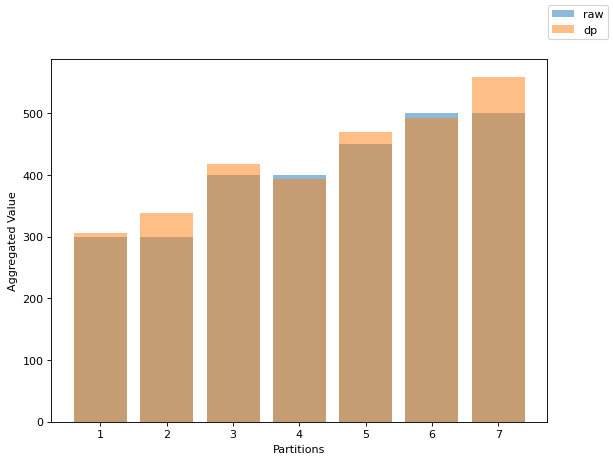

In [11]:
#@title DP Utility Analysis { run: "auto", vertical-output: true}
metrics = [dp_metric]
total_epsilon =  1#@param {type:"number"}
total_delta=1e-5 #@param {type:"number"}
max_partitions_contributed=7 #@param {type:"number"}
max_contributions_per_partition=1 #@param {type:"number"}
# Specify local backend because utility anlysis is supposed to be run locally 
# in an interactive environment
pipeline_backend = pipeline_dp.LocalBackend() 
budget_accountant = pipeline_dp.NaiveBudgetAccountant(total_epsilon=total_epsilon,
                                                    total_delta=total_delta)
peeker_engine = utility_analysis.peeker_engine.PeekerEngine(budget_accountant, pipeline_backend)
params = pipeline_dp.AggregateParams(
  noise_kind=pipeline_dp.NoiseKind.LAPLACE,
  metrics=metrics,
  max_partitions_contributed=max_partitions_contributed,
  max_contributions_per_partition=max_contributions_per_partition,
  # the following two parameters are not useful for COUNT
  min_value=0,
  max_value=1)
dp_result = peeker_engine.aggregate_sketches(sketches, params)
budget_accountant.compute_budgets()
dp_result = list(dp_result)

for i, metric in enumerate(metrics):
  print('drawing for metrics: ', metric)
  draw_diff_charts(raw_result, dp_result, i)

diff_metrics(raw_result, dp_result)